https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        # input image は [0,1] なので
        # 平均と標準偏差を下記のように決めて
        # [-1,1] にする
        transforms.Normalize(
            (0.5, 0.5, 0.5),  # mean
            (0.5, 0.5, 0.5),  # std
        )
    ]
)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


torch.Size([4, 3, 32, 32])


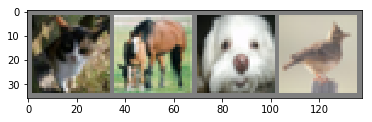

  cat horse   dog  bird


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [6]:
import torch.nn as nn
import torch.nn.functional as F

# 入力画像のサイズL=32
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # ch=3, filter_num=6, filter_size=5
        # 入力チャネルがいくつでもいい感じに畳み込まれるようだ
        self.conv1 = nn.Conv2d(3, 6, 5)
        # (2,2) pooling
        self.pool = nn.MaxPool2d(2, 2)
        # ch=6, filter_num=16, filter_size=5
        self.conv2 = nn.Conv2d(6, 16, 5)
        # この時点で L=5
        # 入力=16フィルタ*5*5
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # L=32 -> 32-5+1 = 28 -> 28/2 -> 14
        x = self.pool(F.relu(self.conv1(x)))
        # L=14 -> 14-5+1 = 10 -> 10/2 -> 5
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [8]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.163
[1,  4000] loss: 1.800
[1,  6000] loss: 1.650
[1,  8000] loss: 1.542
[1, 10000] loss: 1.477
[1, 12000] loss: 1.456
[2,  2000] loss: 1.386
[2,  4000] loss: 1.338
[2,  6000] loss: 1.333
[2,  8000] loss: 1.297
[2, 10000] loss: 1.283
[2, 12000] loss: 1.241
Finished Training


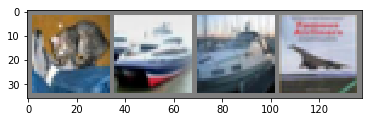

GroundTruth:    cat  ship  ship plane


In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [10]:
outputs = net(images)

In [11]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car   car  ship


In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


In [13]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 57 %
Accuracy of   car : 77 %
Accuracy of  bird : 28 %
Accuracy of   cat : 52 %
Accuracy of  deer : 45 %
Accuracy of   dog : 43 %
Accuracy of  frog : 74 %
Accuracy of horse : 55 %
Accuracy of  ship : 70 %
Accuracy of truck : 60 %
